# FIT5202 Assignment 1 : Analysing eCommerce Data

## Table of Contents  
* 
    * [Part 1 : Working with RDD](#part-1)  
        * [1.1 Data Preparation and Loading](#1.1)  
        * [1.2 Data Partitioning in RDD](#1.2)  
        * [1.3 Query/Analysis](#1.3)  
    * [Part 2 : Working with DataFrames](#2-dataframes)  
        * [2.1 Data Preparation and Loading](#2-dataframes)  
        * [2.2 Query/Analysis](#2.2)  
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

In [503]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession 

# Create Spark Configuration Object
master = "local[*]"
app_name = "FIT5202 Assignment 1"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)\
                        .set("spark.sql.session.timeZone", "Australia/Melbourne")\
                        .set("spark.driver.memory", "8g")

# Create SparkSession
spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Load all CSV files into RDDs.

In [504]:
app_rdd = sc.textFile("A1 dataset/application_data.csv")
pre_app_rdd = sc.textFile("A1 dataset/previous_application.csv")
value_dict_rdd = sc.textFile("A1 dataset/value_dict.csv")

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

In [505]:
# application_data
app_header = app_rdd.first()
app_rdd_1 = app_rdd.filter(lambda x: x != app_header)
print("### Application data RDD ###")
print("Total count: ", app_rdd_1.count())
print("The first 10 records: \n", app_rdd_1.take(10))

# previous_application
pre_app_header = pre_app_rdd.first()
pre_app_rdd_1 = pre_app_rdd.filter(lambda x: x != pre_app_header)
print("\n### Previous application RDD ###")
print("Total count: ", pre_app_rdd_1.count())
print("The first 10 records: \n", pre_app_rdd_1.take(10))

# value_dict
value_dict_header = value_dict_rdd.first()
value_dict_rdd_1 = value_dict_rdd.filter(lambda x: x != value_dict_header)
print("\n### Value dict RDD ###")
print("Total count: ", value_dict_rdd_1.count())
print("The first 10 records: \n", value_dict_rdd_1.take(10))


### Application data RDD ###
Total count:  172591
The first 10 records: 
 ['118100,0,2,F,Y,Y,1,247500.0,667237.5,52848.0,576000.0,2,4,3,6,0.018801,-11258,-1596,13.0,1,1,0,1,0,0,12,3.0,FRIDAY,8,28,0.60994226,0.5884348,,-733.0,,,,,,', '110133,0,2,F,N,Y,2,112500.0,1374480.0,49500.0,1125000.0,8,1,3,6,0.006233,-11044,-942,,1,1,1,1,0,0,16,4.0,MONDAY,10,42,0.7081764,0.6865754,,0.0,,,,,,', '110215,0,2,F,N,Y,0,166500.0,545040.0,26640.0,450000.0,2,1,6,6,0.032561,-17115,-581,,1,1,0,1,1,0,19,1.0,MONDAY,14,22,0.49497995,0.58477587,0.47225335,-1598.0,0.0,0.0,0.0,1.0,0.0,3.0', '194051,0,2,F,N,N,0,112500.0,900000.0,24750.0,900000.0,2,1,2,6,0.015221,-17855,-5470,,1,1,0,1,1,0,8,2.0,FRIDAY,15,30,,0.59620756,0.6195277,-734.0,0.0,0.0,0.0,0.0,0.0,1.0', '110368,0,2,F,N,Y,0,261000.0,1237684.5,47272.5,1138500.0,5,4,3,6,0.020713,-22818,365243,,1,0,0,1,0,0,18,2.0,FRIDAY,10,31,,0.64156574,0.3996756,-979.0,0.0,0.0,0.0,0.0,0.0,0.0', '110498,0,2,F,N,N,0,157500.0,179865.0,11133.0,148500.0,5,1,3,6,0.00496,-21183,36524

###### 1.1.4 Drop the following columns from RDDs:  
previous_application: sellerplace_area, name_seller_industry  
application_data: All columns start with flag_ and amt_credit_req_(except for amt_credit_req_last_year).

In [506]:
pre_app_header = pre_app_rdd.first().split(',')
dropped_pre_indices = [pre_app_header.index('"sellerplace_area"'), pre_app_header.index('"name_seller_industry"')]
app_header = app_rdd.first().split(',')
dropped_app_indices = []
for i in range(len(app_header)):
    if app_header[i].startswith('"flag_') or app_header[i].startswith('"amt_credit_req_') and not app_header[i] == '"amt_credit_req_last_year"':
        dropped_app_indices.append(i)

def drop_pre_app(line):
    array_line = line.split(',')
    
    # Creates a new line with selected columns removed
    new_line = [array_line[i] for i in range(len(array_line)) if i not in dropped_pre_indices]
    return ','.join(new_line)

def drop_app(line):
    array_line = line.split(',')
    new_line = [array_line[i] for i in range(len(array_line)) if i not in dropped_app_indices]
    return ','.join(new_line)

In [507]:
pre_app_rdd_1 = pre_app_rdd.map(drop_pre_app)
pre_app_rdd_1.take(5)

['"id_app","contract_type","amt_annuity","amt_application","amt_credit","amt_down_payment","amt_goods_price","hour_appr_process_start","rate_down_payment","rate_interest_primary","rate_interest_privileged","name_cash_loan_purpose","name_contract_status","days_decision","name_payment_type","code_rejection_reason","name_type_suite","name_client_type","name_goods_category","name_portfolio","name_product_type","channel_type","cnt_payment","name_yield_group","product_combination","days_first_drawing","days_first_due","days_last_due_1st_version","days_last_due","days_termination","nflag_insured_on_approval","id"',
 '269239,3,,0.0,0.0,,,8,,,,XNA,Canceled,-207,XNA,XAP,"",Repeater,XNA,XNA,XNA,"6",,XNA,Cash,,,,,,,65',
 '221473,3,,0.0,0.0,,,8,,,,XNA,Canceled,-317,XNA,XAP,"",Refreshed,XNA,XNA,XNA,"6",,XNA,Cash,,,,,,,7817',
 '107678,4,,24480.0,24480.0,0.0,24480.0,12,0.0,,,XAP,Refused,-1252,Cash through the bank,LIMIT,"",Repeater,Mobile,XNA,XNA,"3",,XNA,POS mobile with interest,,,,,,,172',
 '168941,

In [508]:
app_rdd_1 = app_rdd.map(drop_app)
app_rdd_1.take(5)

['"id_app","target","contract_type","gender","own_car","own_property","num_of_children","income_total","amt_credit","amt_annuity","amt_goods_price","income_type","education_type","family_status","housing_type","region_population","days_birth","days_employed","own_car_age","occupation_type","cnt_fam_members","weekday_app_process_start","hour_app_process_start","organization_type","credit_score_1","credit_score_2","credit_score_3","days_last_phone_change","amt_credit_req_last_year"',
 '118100,0,2,F,Y,Y,1,247500.0,667237.5,52848.0,576000.0,2,4,3,6,0.018801,-11258,-1596,13.0,12,3.0,FRIDAY,8,28,0.60994226,0.5884348,,-733.0,',
 '110133,0,2,F,N,Y,2,112500.0,1374480.0,49500.0,1125000.0,8,1,3,6,0.006233,-11044,-942,,16,4.0,MONDAY,10,42,0.7081764,0.6865754,,0.0,',
 '110215,0,2,F,N,Y,0,166500.0,545040.0,26640.0,450000.0,2,1,6,6,0.032561,-17115,-581,,19,1.0,MONDAY,14,22,0.49497995,0.58477587,0.47225335,-1598.0,3.0',
 '194051,0,2,F,N,N,0,112500.0,900000.0,24750.0,900000.0,2,1,2,6,0.015221,-17855,-5

### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition. Answer the following questions:   
How many partitions do the above RDDs have?   
How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy?   
Can you explain why it will be partitioned in this number? If I only have one single-core CPU on my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.)   
Write the code and your explanation in Markdown cells.

a. How many partitions do the above RDDs have?

In [509]:
def print_partitions(data):
    numPartitions = data.getNumPartitions()
    partitions = data.glom().collect()
    
    print(f"NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")


# application_data
print("### Application data ###")
print_partitions(app_rdd)

# previous_application
print("\n### Previous application ###")
print_partitions(pre_app_rdd)

# value_dict
print("\n### Value dict ###")
print_partitions(value_dict_rdd)

### Application data ###
NUMBER OF PARTITIONS: 2
Partition 0: 86273 records
Partition 1: 86319 records

### Previous application ###
NUMBER OF PARTITIONS: 6
Partition 0: 167805 records
Partition 1: 163835 records
Partition 2: 162603 records
Partition 3: 162683 records
Partition 4: 162437 records
Partition 5: 115675 records

### Value dict ###
NUMBER OF PARTITIONS: 2
Partition 0: 67 records
Partition 1: 60 records


b. How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy?

The number of partitions is determined by the number of cores by default. Spark will automatically distributes the data based on the available resources. hash

c. Can you explain why it will be partitioned in this number? If I only have one single-core CPU on my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.)

These Rdds are partitioned based on the number of cores, in the Spark environment. Default partitioning aims to balance the workload for effficient parallel processing. Since the data size of previous_application.csv is larger than the data size of application_data.csv and value_dict.csv, previous_data.csv needs more partitions than application_data.csv and value_dict.csv.


According to the source code, the minimum partitions of the data read from textFile function is 2. Therefore, even though there is only one single-core CPU in the computer, the partition will be 2. However, the paralleling processing will be limited that it will result in serial processing due to the single core.

1.2.2. The metadata shows that days in the dataset are stored as a relative number. For example, if the application date is 2/Jan/2024, -1 means 1/Jan/2024, -2 means 31/Dec/2023.  
Create a UDF function that takes two parameters: a date and an integer value, and returns a date.   (note: the integer can be either positive or negative). (3%)  
Assuming all applications are made on 1/Jan/2024, create a new column named decision_date, use the UDF function to fill its values from days_decisions (3%)

In [510]:
from datetime import datetime, timedelta

# The function calculates the decision date
def date_calculate(date, days_decision): 
    date_decision = date + timedelta(days = days_decision)
    return date_decision.strftime('%Y-%m-%d')


# The function adds the new column to each row
def add_date_decision(line):
    line_list = line.split(',')
    
    # Converts days_decision to an integer
    days_decision = int(line_list[days_decision_index])
    
    # Calculates the decision date with the date_calculate function
    date_decision = date_calculate(date, days_decision)
    return ','.join(line_list + [date_decision])

# Removes the header
header= pre_app_rdd.first()
pre_app_no_header_rdd = pre_app_rdd.filter(lambda x: x != header)

# Finds the index of "days_decision"
header_list = header.split(',')
days_decision_index = header_list.index('"days_decision"')

date = datetime(2024, 1, 1)

# Calculates the decision date and adds a new column
pre_app_rdd_new = pre_app_no_header_rdd.map(add_date_decision)
new_header = ','.join(pre_app_header + ['"decision_date"'])
pre_app_rdd_with_header = sc.parallelize([new_header] + pre_app_rdd_new.collect())
pre_app_rdd_with_header_1 = pre_app_rdd_with_header.map(lambda x: (x.split(',')[0], x.split(',')[days_decision_index], x.split(',')[-1]))
pre_app_rdd_with_header_1.take(10)

[('"id_app"', '"days_decision"', '"decision_date"'),
 ('269239', '-207', '2023-06-08'),
 ('221473', '-317', '2023-02-18'),
 ('107678', '-1252', '2020-07-28'),
 ('168941', '-633', '2022-04-08'),
 ('204082', '-368', '2022-12-29'),
 ('148658', '-419', '2022-11-08'),
 ('190200', '-405', '2022-11-22'),
 ('152739', '-413', '2022-11-14'),
 ('265668', '-231', '2023-05-15')]

1.2.3. Join application_data and previous_application with value_dict and replace integer values with string values from the dictionary. (5%)

In [511]:
def parseLine(line):
    line = line.split(',')
    return line

# The function aims to match the category in the value dict Rdd and attributes in the header
def search_category(header_list, rdd):
    category_list = []
    rdd_list = rdd.map(parseLine).collect()
    for i in range(len(header_list)):
        for v in rdd_list:
            if header_list[i].strip('"') == v[1]:
                if [i, header_list[i]] not in category_list:
                    category_list.append([i, header_list[i]])      
    return category_list

# The function adds the index in RDD
def add_index(category_list, line):
    line_list = line.split(',')
    
    for c in category_list: 
    # Check the category index in line_list
        if c[1].strip('"') == line_list[1]:
            return ','.join(line_list + [str(c[0])])
    else:
        return line

# The function replaces integers with strings
def replace_integer(line, value_list):
    line_list = line.split(',')
    for v in value_list:
        if line_list[v[0]] == v[1][0]:
            line_list[v[0]] = v[1][1]
    
    return ','.join(line_list)

### joins application_data and value_dict
app_header_list = app_rdd_1.first().split(',') 
category_app = search_category(app_header_list, value_dict_rdd)

# adds index and filter the line with index
result_rdd = value_dict_rdd_1.map(lambda x: add_index(category_app, x))
result_rdd_1 = result_rdd.filter(lambda x: len((x.split(','))) == 5)

app_header = app_rdd_1.first()
app_rdd_2= app_rdd_1.filter(lambda x: x != app_header)

# formats RDD
value_format = result_rdd_1.map(parseLine).map(lambda x: (int(x[4]), [x[3], x[2]]))
value_list = value_format.collect()

# replaces integers and formats application data RDD
app_rdd_replaced = app_rdd_2.map(lambda x: replace_integer(x, value_list))
app_rdd_header = sc.parallelize([app_header] + app_rdd_replaced.collect()) 

### join pre_application data and value_dict
pre_header_list = pre_app_rdd_1.first().split(',')  
category_pre = search_category(pre_header_list, value_dict_rdd)

# adds index and filter the line with index
result_rdd = value_dict_rdd_1.map(lambda x: add_index(category_pre, x))
result_rdd_1 = result_rdd.filter(lambda x: len((x.split(','))) == 5)

pre_header = pre_app_rdd_1.first()
pre_rdd_2= pre_app_rdd_1.filter(lambda x: x != pre_header)

# formats RDD
value_format = result_rdd_1.map(parseLine).map(lambda x: (int(x[4]), [x[3], x[2]]))
value_list = value_format.collect()

# replaces integers and formats application data RDD
pre_rdd_replaced = pre_rdd_2.map(lambda x: replace_integer(x, value_list))
pre_rdd_header = sc.parallelize([pre_header] + pre_rdd_replaced.collect()) 

In [512]:
app_rdd_header.take(10)

['"id_app","target","contract_type","gender","own_car","own_property","num_of_children","income_total","amt_credit","amt_annuity","amt_goods_price","income_type","education_type","family_status","housing_type","region_population","days_birth","days_employed","own_car_age","occupation_type","cnt_fam_members","weekday_app_process_start","hour_app_process_start","organization_type","credit_score_1","credit_score_2","credit_score_3","days_last_phone_change","amt_credit_req_last_year"',
 '118100,0,Revolving loans,F,Y,Y,1,247500.0,667237.5,52848.0,576000.0,Working,Higher education,Married,House / apartment,0.018801,-11258,-1596,13.0,Laborers,3.0,FRIDAY,8,Government,0.60994226,0.5884348,,-733.0,',
 '110133,0,Revolving loans,F,N,Y,2,112500.0,1374480.0,49500.0,1125000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,0.006233,-11044,-942,,Sales staff,4.0,MONDAY,10,Trade: type 7,0.7081764,0.6865754,,0.0,',
 '110215,0,Revolving loans,F,N,Y,0,166500.0,545040.0,26640.0,

In [513]:
pre_rdd_header.take(10)

['"id_app","contract_type","amt_annuity","amt_application","amt_credit","amt_down_payment","amt_goods_price","hour_appr_process_start","rate_down_payment","rate_interest_primary","rate_interest_privileged","name_cash_loan_purpose","name_contract_status","days_decision","name_payment_type","code_rejection_reason","name_type_suite","name_client_type","name_goods_category","name_portfolio","name_product_type","channel_type","cnt_payment","name_yield_group","product_combination","days_first_drawing","days_first_due","days_last_due_1st_version","days_last_due","days_termination","nflag_insured_on_approval","id"',
 '269239,Cash loans,,0.0,0.0,,,8,,,,XNA,Canceled,-207,XNA,XAP,"",Repeater,XNA,XNA,XNA,"6",,XNA,Cash,,,,,,,65',
 '221473,Cash loans,,0.0,0.0,,,8,,,,XNA,Canceled,-317,XNA,XAP,"",Refreshed,XNA,XNA,XNA,"6",,XNA,Cash,,,,,,,7817',
 '107678,Consumer loans,,24480.0,24480.0,0.0,24480.0,12,0.0,,,XAP,Refused,-1252,Cash through the bank,LIMIT,"",Repeater,Mobile,XNA,XNA,"3",,XNA,POS mobile with

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Calculate the total approved loan amount for each year, each month. Print the results in the format of year, month, total_amount. (5%)**

In [514]:
# Parses records and return decision year-month, loan amount, and contract status
def extract_data(line):
    line = line.split(',')
    return line[-1][:7],line[loan_index],line[status_index]

pre_app_rdd_2 = pre_app_rdd_with_header

# Finds the indices of amt_credit and name_contract_status
pre_app_header_list = pre_app_rdd_2.first().split(',')
loan_index = pre_app_header_list.index('"amt_credit"')
status_index = pre_app_header_list.index('"name_contract_status"')

# Removes the header, extracts year and month, filters the data
pre_app_rdd_3 = pre_app_rdd_2.filter(lambda x: x != pre_app_header).map(extract_data).filter(lambda x: x[2] == "Approved")\
                            .map(lambda x: (x[0], float(x[1])))
                            

# Calculates the amount and sorts the data
total_rdd = pre_app_rdd_3.reduceByKey(lambda a, b: a + b)\
                        .sortBy(lambda x: (int(x[0][:4]), int(x[0][5:7])), ascending = True)

total = total_rdd.collect()

for year_month, total_amount in total:
    year, month = year_month[:4], year_month[5:7]
    print(f"Year: {year}, Month: {month}, Total Amount: {total_amount}")

Year: 2016, Month: 01, Total Amount: 172331955.0
Year: 2016, Month: 02, Total Amount: 176301522.0
Year: 2016, Month: 03, Total Amount: 190586187.0
Year: 2016, Month: 04, Total Amount: 196686805.5
Year: 2016, Month: 05, Total Amount: 195882363.0
Year: 2016, Month: 06, Total Amount: 200585488.5
Year: 2016, Month: 07, Total Amount: 228541482.0
Year: 2016, Month: 08, Total Amount: 241038688.5
Year: 2016, Month: 09, Total Amount: 252035883.0
Year: 2016, Month: 10, Total Amount: 271204798.5
Year: 2016, Month: 11, Total Amount: 270581526.0
Year: 2016, Month: 12, Total Amount: 297452236.5
Year: 2017, Month: 01, Total Amount: 314613220.5
Year: 2017, Month: 02, Total Amount: 279918481.5
Year: 2017, Month: 03, Total Amount: 326222946.0
Year: 2017, Month: 04, Total Amount: 336857661.0
Year: 2017, Month: 05, Total Amount: 315156078.0
Year: 2017, Month: 06, Total Amount: 272737849.5
Year: 2017, Month: 07, Total Amount: 302933970.0
Year: 2017, Month: 08, Total Amount: 298022152.5
Year: 2017, Month: 0

**1.3.2 For each hour when the applications start (0-23), compute and print the percentage ratio of application cancellation. (5%)**

In [515]:
def parseRow(line):
    line = line.split(',')
    
    # if the application is cancelled
    if line[status_index] == "Canceled":
        return line[hour_index], 1, 1
    
    else:
        return line[hour_index], 1, 0

# Finds the indices of target attributes
pre_app_rdd_2 = pre_app_rdd_with_header
pre_app_header_list = pre_app_rdd_2.first().split(',')
hour_index = pre_app_header_list.index('"hour_appr_process_start"')
status_index = pre_app_header_list.index('"name_contract_status"')

pre_app_header = pre_app_rdd_2.first()
pre_app_rdd_4 = pre_app_rdd_2.filter(lambda x: x != pre_app_header)   
pre_app_rdd_4 = pre_app_rdd_4.map(parseRow)

# Calculates the total number of applications and the number of cancelled applications
total_rdd = pre_app_rdd_4.map(lambda x: (x[0], (x[1], x[2]))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# Calculates the ratio
ratio_rdd = total_rdd.map(lambda x: (x[0], x[1][1] / x[1][0] * 100)).sortBy(lambda x: int(x[0]), ascending = True)
ratio = ratio_rdd.collect()

for hour, ratio in ratio:
    print(f"Hour: {hour}, Ratio: {ratio}")

Hour: 0, Ratio: 11.864406779661017
Hour: 1, Ratio: 31.2
Hour: 2, Ratio: 37.850467289719624
Hour: 3, Ratio: 31.748911465892597
Hour: 4, Ratio: 26.306850349122474
Hour: 5, Ratio: 24.281113411548194
Hour: 6, Ratio: 22.477605721824872
Hour: 7, Ratio: 22.43704685429173
Hour: 8, Ratio: 20.612833628275677
Hour: 9, Ratio: 22.198257633426373
Hour: 10, Ratio: 21.436402435443135
Hour: 11, Ratio: 19.65048973902126
Hour: 12, Ratio: 18.78137858595203
Hour: 13, Ratio: 18.17456782706868
Hour: 14, Ratio: 18.078999715828363
Hour: 15, Ratio: 17.791441774260203
Hour: 16, Ratio: 17.52002940095553
Hour: 17, Ratio: 16.7146482821319
Hour: 18, Ratio: 14.318538444295001
Hour: 19, Ratio: 10.293274990883992
Hour: 20, Ratio: 7.287947802536008
Hour: 21, Ratio: 10.340196956132498
Hour: 22, Ratio: 18.159806295399516
Hour: 23, Ratio: 11.711711711711711


## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load CSVs into separate dataframes. When you create your dataframes, please refer to the metadata file and use appropriate data type for each column.**

In [516]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType

# Load CSVs
df_app = spark.read.csv("A1 dataset/application_data.csv", header = True)
df_pre_app = spark.read.csv("A1 dataset/previous_application.csv", header = True)
df_value = spark.read.csv("A1 dataset/value_dict.csv", header = True)

def change_datatype(df, column_dictionary):
    for column, data_type in column_dictionary.items():
        df = df.withColumn(column, F.col(column).cast(data_type))
    return df

# application data dictionary
app_data_column = {
    "num_of_children": IntegerType(),
    "income_total": FloatType(),
    "amt_credit": FloatType(),
    "amt_annuity": FloatType(),
    "amt_goods_price": FloatType(),
    "region_population": FloatType(),
    "days_birth": IntegerType(),
    "days_employed": IntegerType(),
    "own_car_age": IntegerType(),
    "cnt_fam_members": IntegerType(),
    "credit_score_1": FloatType(),
    "credit_score_2": FloatType(),
    "credit_score_3": FloatType(),
    "days_last_phone_change": IntegerType(),
    "amt_credit_req_last_hour": IntegerType(),
    "amt_credit_req_last_day": IntegerType(),
    "amt_credit_req_last_week": IntegerType(),
    "amt_credit_req_last_month": IntegerType(),
    "amt_credit_req_last_quarter": IntegerType(),
    "amt_credit_req_last_year": IntegerType()
}

#previous application dictionary
pre_data_column = {
    "amt_annuity": FloatType(),
    "amt_application": FloatType(),
    "amt_credit": FloatType(),
    "amt_down_payment": FloatType(),
    "amt_goods_price": FloatType(),
    "rate_down_payment": FloatType(),
    "rate_interest_primary": FloatType(),
    "rate_interest_privileged": FloatType(),
    "days_decision": IntegerType(),
    "sellerplace_area": IntegerType(),
    "cnt_payment": IntegerType(),
    "days_first_drawing": IntegerType(),
    "days_first_due": IntegerType(),
    "days_last_due_1st_version": IntegerType(),
    "days_last_due": IntegerType(),
    "days_termination": IntegerType()
}

df_app = change_datatype(df_app, app_data_column)
df_pre_app = change_datatype(df_pre_app, pre_data_column)

**2.1.2 Display the schema of all dataframes.**

In [517]:
print(f"####### application_data.csv INFO:")
df_app.printSchema()

print(f"####### previous_application.csv INFO:")
df_pre_app.printSchema()

print(f"####### value_dict.csv INFO:")
df_value.printSchema()

####### application_data.csv INFO:
root
 |-- id_app: string (nullable = true)
 |-- target: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- own_car: string (nullable = true)
 |-- own_property: string (nullable = true)
 |-- num_of_children: integer (nullable = true)
 |-- income_total: float (nullable = true)
 |-- amt_credit: float (nullable = true)
 |-- amt_annuity: float (nullable = true)
 |-- amt_goods_price: float (nullable = true)
 |-- income_type: string (nullable = true)
 |-- education_type: string (nullable = true)
 |-- family_status: string (nullable = true)
 |-- housing_type: string (nullable = true)
 |-- region_population: float (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- own_car_age: integer (nullable = true)
 |-- flag_mobile: string (nullable = true)
 |-- flag_emp_phone: string (nullable = true)
 |-- flag_work_phone: string (nullable = true)
 |-

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

**2.2.1. alculate the average income for each education_type group, and print the result. (4%)**

In [518]:
df_avg_income = df_app.groupBy("education_type").agg(F.avg("income_total").alias("average_income"))
df_avg_income = df_avg_income.orderBy("education_type", ascending = True)

df_avg_income.show()

+--------------+-----------------+
|education_type|   average_income|
+--------------+-----------------+
|             1|155155.7391775319|
|             2|181014.4486888112|
|             3|128151.7258064516|
|             4|209339.6391128193|
|             5|         227110.0|
+--------------+-----------------+



**2.2.2. Find the applicants who made credit requests last year with an average credit score of less than 0.5 from the three credit rating sources. (note: impute null value in credit score with 0.5, not 0). (4%)**

In [519]:
# Inputs 0.5 for null value
df_app = df_app.withColumn("credit_score_1", F.coalesce("credit_score_1", F.lit(0.5)))\
                .withColumn("credit_score_2", F.coalesce("credit_score_2", F.lit(0.5)))\
                .withColumn("credit_score_3", F.coalesce("credit_score_3", F.lit(0.5)))

# Filters the joined table with the conditions
df_credit = df_app.withColumn("average_credit_score", (df_app.credit_score_1 + df_app.credit_score_2 + df_app.credit_score_3)/3)
df_credit_1 = df_credit.filter(F.col("average_credit_score") < 0.5).filter(F.col("amt_credit_req_last_year") > 0)\
                        .orderBy(F.col("id_app"))
df_applicant = df_credit_1.select("id_app", "average_credit_score").distinct().show()

+------+--------------------+
|id_app|average_credit_score|
+------+--------------------+
|170773| 0.38805461426575977|
|207396|   0.312442605694135|
|297564|  0.3646637921531995|
|105259| 0.40238819519678753|
|110064| 0.27770336469014484|
|112434|  0.3429948588212331|
|113292|   0.474180946747462|
|185297|  0.4968619147936503|
|187412| 0.45689691106478375|
|189219| 0.38212726016839343|
|130816| 0.42631927132606506|
|140141|  0.4787156780560811|
|117530|  0.4869733254114787|
|117754|  0.3643556733926137|
|120138| 0.46015167484680813|
|122626|   0.288748433192571|
|113473|  0.4514952600002289|
|125633| 0.47104446093241376|
|128701| 0.49194658795992535|
|129248| 0.43062155445416767|
+------+--------------------+
only showing top 20 rows



**2.2.3. Transform the 'days_birth' column in the application_data to age(integer rounded down) and date_of_birth; then show the schema. You are allowed to use the UDF defined in part 1. (4%)**

In [520]:
import math
from datetime import datetime, timedelta
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType

def date_calculate(date, days_birth): 
    birth_date = date + timedelta(days = days_birth)
    return birth_date

def age_calculate(days_birth):
    age = math.floor(days_birth/-365)
    return age

date = datetime(2024,1,1)

# Registers the functions as UDFs
date_calculate_udf = udf(date_calculate, DateType())
age_calculate_udf = udf(age_calculate, IntegerType())

# Calculates the age and birth dates, and adds columns
df_added = df_app.withColumn("date_of_birth", date_calculate_udf(F.lit(date), F.col("days_birth"))) \
                 .withColumn("age", age_calculate_udf(F.col("days_birth")))

df_result = df_added.drop("days_birth")

df_result.select("id_app", "age", "date_of_birth").show()
df_result.printSchema()

+------+---+-------------+
|id_app|age|date_of_birth|
+------+---+-------------+
|118100| 30|   1993-03-06|
|110133| 30|   1993-10-06|
|110215| 46|   1977-02-21|
|194051| 48|   1975-02-12|
|110368| 62|   1961-07-12|
|110498| 58|   1966-01-02|
|110561| 26|   1997-11-21|
|110836| 36|   1987-06-13|
|110985| 46|   1977-11-16|
|109621| 29|   1994-05-10|
|111097| 50|   1973-12-15|
|111245| 54|   1970-01-14|
|111288| 31|   1992-02-22|
|165103| 32|   1991-02-12|
|111444| 36|   1987-04-23|
|111509| 54|   1969-08-08|
|111556| 46|   1977-03-12|
|111642| 47|   1976-06-27|
|111869| 58|   1965-12-18|
|158585| 32|   1991-06-06|
+------+---+-------------+
only showing top 20 rows

root
 |-- id_app: string (nullable = true)
 |-- target: string (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- own_car: string (nullable = true)
 |-- own_property: string (nullable = true)
 |-- num_of_children: integer (nullable = true)
 |-- income_total: float (nulla

**2.2.4. Using an age bucket of 10(0-10, 11-20, 21-30, etc..), compute the percentage of applicants owning a car and a property. (8%)**

In [521]:
from pyspark.sql.types import StringType

age_range = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

def classify_age(age):
    for i in range(len(age_range)):
        if age_range[i] < age <= age_range[i + 1]:
            return f"{age_range[i]+1}-{age_range[i + 1]}"
    return "100+"


# Registers the UDF
classify_age_udf = udf(classify_age, StringType())

# Calculate the age, bucketize it, and calculate ownership percentages
df_age = df_result.withColumn("age_bucket", classify_age_udf(F.col("age")))
df_car_property = df_age.withColumn("car_and_property", F.when((F.col("own_car") == "Y") & (F.col("own_property") == "Y"), 1).otherwise(0)).alias("car_and_property_owners")

# Counts total applicants and applicants owning a car and a property
df_count = df_car_property.groupBy("age_bucket").agg(F.count("age").alias("total_applicants"), F.sum("car_and_property").alias("car_and_property_applicants"))

# Adds a new column "percentage"
df_percentage = df_count.withColumn("percentage", (F.col("car_and_property_applicants") / F.col("total_applicants") *100)).select("age_bucket","percentage")
               
df_percentage.sort("age_bucket").show()

+----------+------------------+
|age_bucket|        percentage|
+----------+------------------+
|     21-30|23.338033843674456|
|     31-40|26.909759329714017|
|     41-50| 26.81282832401833|
|     51-60| 20.21760999629375|
|     61-70|13.944920884164755|
+----------+------------------+



**2.2.5. Draw a barchart to show the total number of uncancelled applications from male/female in each year. (10%)**

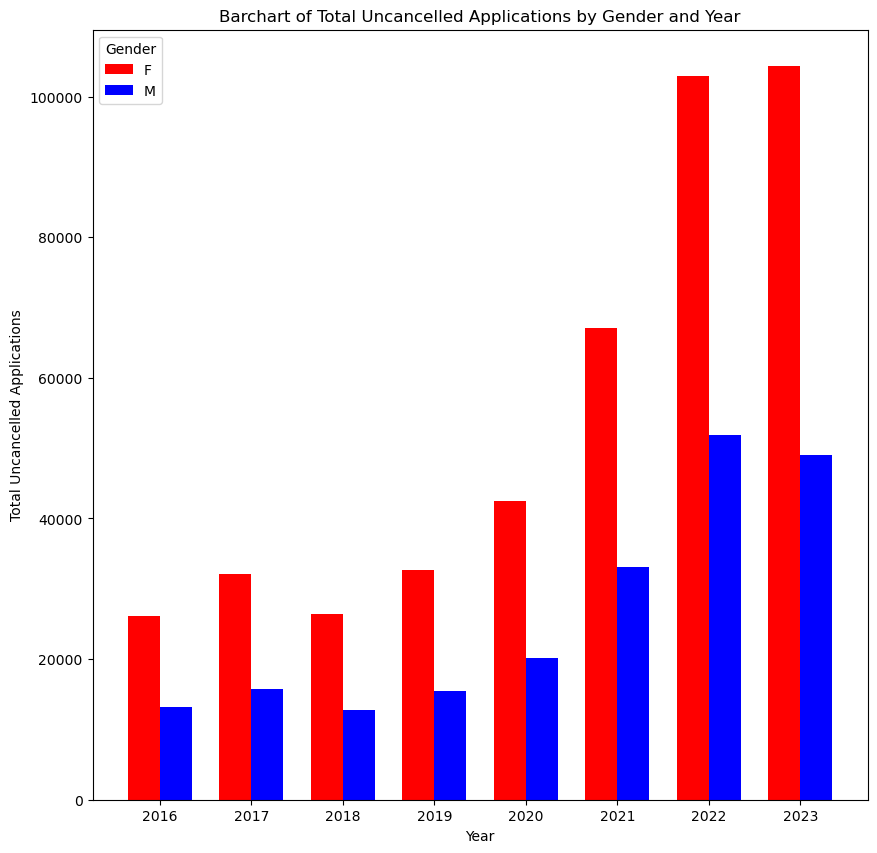

In [522]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def date_calculate(date, days_decision): 
    date_decision = date + timedelta(days = days_decision)
    return date_decision

df_uncanceled = df_pre_app.filter(F.col("name_contract_status") != "Canceled")

date_calculate_udf = udf(date_calculate, DateType())

date = datetime(2024, 1, 1)

df_pre_app_added = df_uncanceled.withColumn("date_decision", date_calculate_udf(F.lit(date), F.col("days_decision"))) \
                                .withColumn("year", F.year("date_decision"))

df_joined = df_pre_app_added.join(df_app, df_pre_app_added.id_app == df_app.id_app, how = "left_outer")

# Groups the joined dfs by gender and year, and count the total applications
df_grouped = df_joined.groupBy("gender", "year").agg(F.count("name_contract_status").alias("total_applications"))\
                        .orderBy(F.col("year"))
df_grouped_filtered = df_grouped.filter((F.col("gender") != "NULL") & (F.col("gender") != "XNA"))

#df_grouped_filtered.orderBy("year","gender").show()

# Plots a barchart
plot_data = df_grouped_filtered.toPandas()
plt.figure(figsize=(10, 10))

# Creates side-by-side bars for different genders in the same year
unique_years = plot_data["year"].unique()
bar_width = 0.35 
index = range(len(unique_years))
colors = {'F': 'red', 'M': 'blue'}

for i, gender in enumerate(plot_data["gender"].unique()):
    gender_data = plot_data[plot_data["gender"] == gender]
    plt.bar([pos + i * bar_width for pos in index], gender_data["total_applications"],\
            bar_width, label = gender, color = colors[gender])

plt.title("Barchart of Total Uncancelled Applications by Gender and Year")
plt.xlabel("Year")
plt.ylabel("Total Uncancelled Applications")
plt.xticks([pos + (bar_width / 2) for pos in index], unique_years)
plt.legend(title="Gender")
plt.show()

**2.2.6. Draw a scatter plot of the applicants’ age and their total approved credit. You may use log scales for the XY axis if necessary. (10%)**

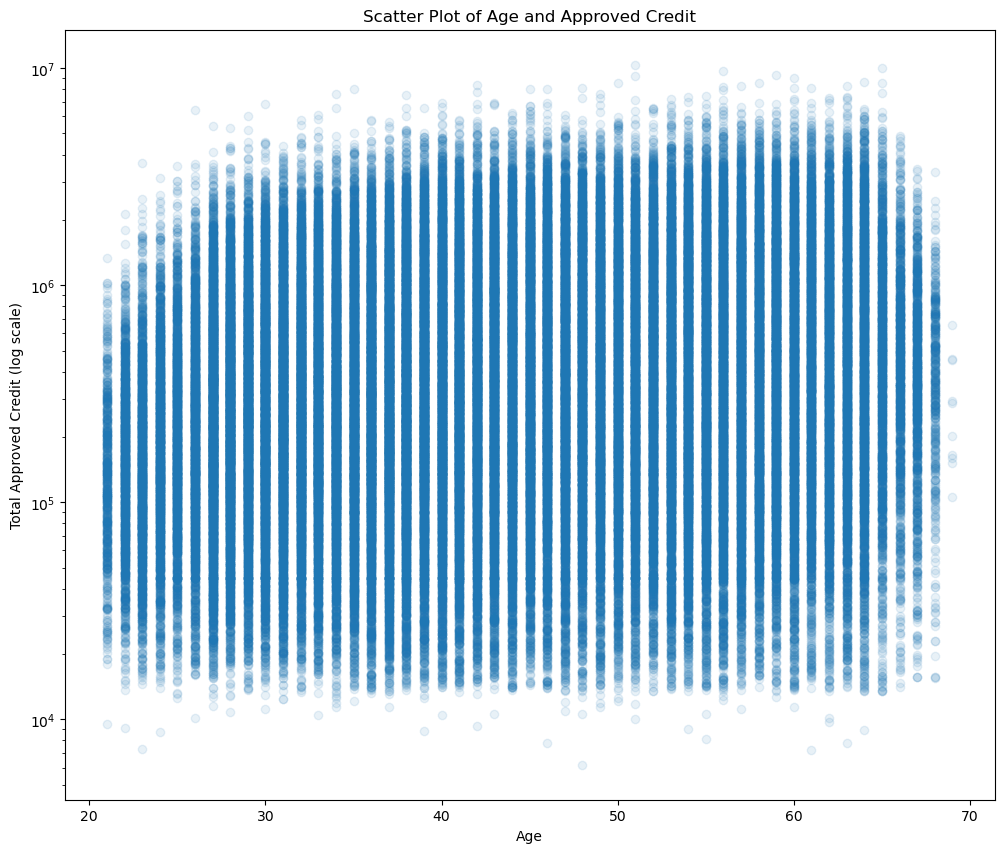

In [523]:
# Calculates applicants' total credit
#df_total_credit = df_pre_app.filter((F.col("amt_credit") != 0) & (F.col("name_contract_status") == "Approved"))\
                           # .groupby(F.col("id_app")).agg(F.sum(F.col("amt_credit")).alias("total_approved_credit"))

df_total_credit = df_pre_app.filter((F.col("name_contract_status") == "Approved"))\
                            .groupby(F.col("id_app")).agg(F.sum(F.col("amt_credit")).alias("total_approved_credit"))

# Joins the dataframes to get the applicants' age
df_added_1 = df_added.withColumnRenamed("id_app", "id_app_1")
df_joined = df_total_credit.join(df_added_1, df_total_credit.id_app == df_added_1.id_app_1, how = "left_outer")
df_age_credit = df_joined.filter(F.col("age").isNotNull())
df_age_credit = df_age_credit.select("id_app","age", "total_approved_credit")
df_age_credit.count()

# Plots a scatter graph
plot_data = df_age_credit.toPandas()
plt.figure(figsize = (12, 10))

# Scatter plot with log scales
plt.scatter(plot_data["age"], plot_data["total_approved_credit"], alpha = 0.1)
plt.yscale('log')
plt.title("Scatter Plot of Age and Approved Credit")
plt.xlabel("Age")
plt.ylabel("Total Approved Credit (log scale)")
plt.show()
#df_age_credit.count()

### Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames in SparkSQL separately. Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these three approaches.


#### Complex Query (high-risk applicants): Find the top 100 applicants who are married with children and have a total approved credit that is more than five times their incomes (regardless of any payments made), sorted by the total credit/income ratio. (hint: intermediate dataframes/tables are allowed if necessary)


#### 3.1. RDD Implementation

In [524]:
%%time

#value_dict_rdd.collect()

def parseLine(line):
    line = line.split(',')
    return line

def map_to_kvp(line):
    if len(line) < 3:
        return line
    return line[0], line[1:]

def add_ratio(x):
    ratio = int(x[1][1]) / int(x[1][0][0])
    return x[0], x[1], ratio

# Filters out the values of family status
value_dict_rdd_1 = value_dict_rdd.map(parseLine)
value_header = value_dict_rdd_1.first()
value_dict_rdd_1 = value_dict_rdd_1.filter(lambda line: line != value_header)
value = value_dict_rdd_1.filter(lambda x: x[1] == "family_status").filter(lambda x: x[2] == "Married").map(lambda x: x[3]).collect()


# Filters the conditions in the application data
app_rdd_1 = app_rdd.map(parseLine)
app_header = app_rdd_1.first()
children_index = app_header.index('"num_of_children"')
fam_index = app_header.index('"family_status"')
income_index = app_header.index('"income_total"')
app_rdd_1 = app_rdd_1.filter(lambda x: x != app_header)
app_filtered_rdd = app_rdd_1.filter(lambda x: int(x[children_index]) > 0 and x[fam_index] == value[0])
app_filtered_rdd_1 = app_filtered_rdd.map(lambda x: (x[0], float(x[income_index]), x[children_index], x[fam_index]))

#Filters the conditions in the previous application data
pre_rdd_1 = pre_app_rdd.map(parseLine)
pre_header = pre_rdd_1.first()
status_index = pre_header.index('"name_contract_status"')
credit_index = pre_header.index('"amt_credit"')
pre_rdd_1 = pre_rdd_1.filter(lambda x: x != pre_header)
pre_filtered_rdd = pre_rdd_1.filter(lambda x: x[status_index] == "Approved")

# Calculates total credit
pre_filtered_rdd_1 = pre_filtered_rdd.map(lambda x: (x[0], float(x[credit_index])))
pre_filtered_rdd_1 = pre_filtered_rdd_1.reduceByKey(lambda a, b: a + b)

# Joins the application RDD and previous application RDD
joined_rdd = app_filtered_rdd_1.map(map_to_kvp).join(pre_filtered_rdd_1.map(map_to_kvp))
joined_rdd_cal = joined_rdd.filter(lambda x : x[1][1] > 5 * x[1][0][0])
joined_rdd_cal.map(lambda x : (x[0], list(x[1:])))

# Calculates the ratio and sorts by ratio
joined_ratio =  joined_rdd_cal.map(add_ratio).map(lambda x: (x[0], x[1][0][0], x[1][0][1], x[1][0][2], x[1][1], x[2]))
sorted_ratio = joined_ratio.sortBy(lambda x: x[5], ascending=False)

new_header = ('id_app', 'income_total', 'num_of_children', 'family_status', 'amt_credit', 'name_contract_status', 'credit_income_ratio')

# Combines the new header with the RDD data
sorted_ratio_header = sc.parallelize([new_header] + sorted_ratio.collect())
sorted_ratio_header.take(100)

CPU times: user 87.3 ms, sys: 17.1 ms, total: 104 ms
Wall time: 5.31 s


[('id_app',
  'income_total',
  'num_of_children',
  'family_status',
  'amt_credit',
  'name_contract_status',
  'credit_income_ratio'),
 ('147568', 67500.0, '1', '3', 4706523.0, 69.72626666666666),
 ('266003', 112500.0, '1', '3', 6690141.0, 59.46792),
 ('200310', 90000.0, '3', '3', 5042700.0, 56.03),
 ('266599', 67500.0, '1', '3', 3722490.0, 55.148),
 ('211517', 90000.0, '2', '3', 4604098.5, 51.156644444444446),
 ('260331', 88650.0, '1', '3', 4146012.0, 46.76832487309645),
 ('104007', 72000.0, '2', '3', 3353157.0, 46.571625),
 ('164041', 85500.0, '2', '3', 3876021.0, 45.33357894736842),
 ('171460', 90000.0, '1', '3', 4015030.5, 44.611444444444444),
 ('250994', 67500.0, '1', '3', 2992275.0, 44.33),
 ('134516', 49500.0, '2', '3', 2098467.0, 42.39327272727273),
 ('119480', 58500.0, '1', '3', 2417764.5, 41.329299145299146),
 ('270590', 67500.0, '1', '3', 2788060.5, 41.30459259259259),
 ('235212', 45000.0, '1', '3', 1852314.0, 41.162533333333336),
 ('299356', 67500.0, '1', '3', 2742232.5,

#### 3.2. DataFrame Implementation

In [525]:
%%time

# Finds the value of "Married" in value_dict
df_value_filtered = df_value.filter((F.col("category") == "family_status") & (F.col("key") == "Married"))
value = df_value_filtered.collect()[0]['value']

df_app_filtered = df_app.filter((F.col("num_of_children") > 0) & (F.col("family_status") == value))

# Change the column name to avoid replicate column name after joining dfs
df_app_filtered_1 = df_app_filtered.withColumnRenamed("amt_credit", "amt_credit_1").withColumnRenamed("id_app", "id_app_1")

df_pre_app_filtered = df_pre_app.filter(F.col("name_contract_status") == "Approved")

df_joined = df_pre_app_filtered.join(df_app_filtered_1, df_pre_app_filtered.id_app == df_app_filtered_1.id_app_1, how = "left_outer")

df_joined = df_joined.select("id_app", "num_of_children", "family_status", "amt_credit", "name_contract_status", "income_total")\
                     .filter(F.col("income_total") != 0)

# Calculates the total credit of id_app
df_joined_1 = df_joined.groupby("id_app").agg(F.sum(F.col("amt_credit")).alias("total_credit"))
df_joined_1 = df_joined_1.withColumnRenamed("id_app", "id_app_2")

# Joins the dfs to get other attributes
df_joined_2 = df_joined.join(df_joined_1, df_joined.id_app == df_joined_1.id_app_2, how = "inner")

# Calculates the ratio and filters the total credit > 5 times of total income
df_result = df_joined_2.select("id_app", "num_of_children", "family_status", "total_credit", "name_contract_status","income_total")\
                        .withColumn("credit_income_ratio", F.col("total_credit") / F.col("income_total"))\
                        .filter(F.col("total_credit") > 5 * F.col("income_total")).distinct()\
                        .sort("credit_income_ratio", ascending=False)

df_result.show(100)

+------+---------------+-------------+-------------+--------------------+------------+-------------------+
|id_app|num_of_children|family_status| total_credit|name_contract_status|income_total|credit_income_ratio|
+------+---------------+-------------+-------------+--------------------+------------+-------------------+
|147568|              1|            3|    4706523.0|            Approved|     67500.0|  69.72626666666666|
|266003|              1|            3|    6690141.0|            Approved|    112500.0|           59.46792|
|200310|              3|            3|    5042700.0|            Approved|     90000.0|              56.03|
|266599|              1|            3|    3722490.0|            Approved|     67500.0|             55.148|
|211517|              2|            3|    4604098.5|            Approved|     90000.0|           51.15665|
|260331|              1|            3|    4146012.0|            Approved|     88650.0|  46.76832487309645|
|104007|              2|            3

#### 3.3. Spark SQL Implementation

In [526]:
%%time

# Create Views from Dataframes
df_app.createOrReplaceTempView("sql_app")
df_pre_app.createOrReplaceTempView("sql_pre_app")
df_value.createOrReplaceTempView("sql_value")

sql_result = spark.sql("""
    SELECT p.id_app, a.num_of_children, a.family_status, 
           SUM(p.amt_credit) AS total_credit, p.name_contract_status, a.income_total,
           SUM(p.amt_credit) / a.income_total AS credit_income_ratio
    FROM sql_pre_app p
    LEFT JOIN (
        SELECT id_app, num_of_children, family_status, amt_credit, income_total
        FROM sql_app
        WHERE num_of_children > 0 AND family_status = (
            SELECT value FROM sql_value
            WHERE category = 'family_status' AND key = 'Married'
        )
    ) a ON p.id_app = a.id_app
    WHERE p.name_contract_status = 'Approved' AND a.income_total != 0
    GROUP BY p.id_app, a.num_of_children, a.family_status, p.name_contract_status, a.income_total
    HAVING SUM(p.amt_credit) > 5 * a.income_total
    ORDER BY credit_income_ratio DESC
    LIMIT 100
    """)

result_df.show()


+------+---------------+-------------+------------+--------------------+------------+-------------------+
|id_app|num_of_children|family_status|total_credit|name_contract_status|income_total|credit_income_ratio|
+------+---------------+-------------+------------+--------------------+------------+-------------------+
|147568|              1|            3|   4706523.0|            Approved|     67500.0|  69.72626666666666|
|266003|              1|            3|   6690141.0|            Approved|    112500.0|           59.46792|
|200310|              3|            3|   5042700.0|            Approved|     90000.0|              56.03|
|266599|              1|            3|   3722490.0|            Approved|     67500.0|             55.148|
|211517|              2|            3|   4604098.5|            Approved|     90000.0|           51.15665|
|260331|              1|            3|   4146012.0|            Approved|     88650.0|  46.76832487309645|
|104007|              2|            3|   33531

### 3.4 Observe the query execution time among RDD, DataFrame, SparkSQL, which is the fastest and why? (Maximum 500 words.)

The SparkSQL is the fastest. SQL queries are utilised in SparkSQL. Since SQL is high-level language, which allows for more concise and declarative expression to manipulate data.  In addition, SparkSQL is optimised, aiming to generate execution plans for SQL queries with higher efficiency. An enture query plan can be compiled into a single function, reducing the overhead of separately processing each operatiton. Therefore, SparkSQL provides improved performance compared to RDDs and DataFrame.

#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run ...... compared with RDD.


### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html